In [3]:
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
import iris.coord_categorisation
import numpy

In [4]:
hist_file = '/g/data/ua6/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/mon/ocean/r1i1p1/hfds/latest/hfds_Omon_CSIRO-Mk3-6-0_historical_r1i1p1_185001-200512.nc'
area_file = '/g/data/ua6/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/fx/ocean/r0i0p0/areacello/latest/areacello_fx_CSIRO-Mk3-6-0_historical_r0i0p0.nc'

In [5]:
hist_cube = iris.load_cube(hist_file, 'surface_downward_heat_flux_in_sea_water')

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'hfds'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [6]:
area_cube = iris.load_cube(area_file, 'cell_area')

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [7]:
def convert_to_annual(cube, full_months=False, aggregation='mean'):
    """Convert data to annual timescale.
    Args:
      cube (iris.cube.Cube)
      full_months(bool): only include years with data for all 12 months
    """

    iris.coord_categorisation.add_year(cube, 'time')
    iris.coord_categorisation.add_month(cube, 'time')

    if aggregation == 'mean':
        aggregator = iris.analysis.MEAN
    elif aggregation == 'sum':
        aggregator = iris.analysis.SUM

    cube = cube.aggregated_by(['year'], aggregator)

    if full_months:
        cube = cube.extract(iris.Constraint(month='Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec'))
  
    cube.remove_coord('year')
    cube.remove_coord('month')

    return cube


def broadcast_array(array, axis_index, shape):
    """Broadcast an array to a target shape.
    
    Args:
      array (numpy.ndarray)
      axis_index (int or tuple): Postion in the target shape that the 
        axis/axes of the array corresponds to
          e.g. if array corresponds to (depth, lat, lon) in (time, depth, lat, lon)
          then axis_index = [1, 3]
          e.g. if array corresponds to (lat) in (time, depth, lat, lon)
          then axis_index = 2
      shape (tuple): shape to broadcast to
      
    For a one dimensional array, make start_axis_index = end_axis_index
    
    """

    if type(axis_index) in [float, int]:
        start_axis_index = end_axis_index = axis_index
    else:
        assert len(axis_index) == 2
        start_axis_index, end_axis_index = axis_index
    
    dim = start_axis_index - 1
    while dim >= 0:
        array = array[numpy.newaxis, ...]
        array = numpy.repeat(array, shape[dim], axis=0)
        dim = dim - 1
    
    dim = end_axis_index + 1
    while dim < len(shape):    
        array = array[..., numpy.newaxis]
        array = numpy.repeat(array, shape[dim], axis=-1)
        dim = dim + 1

    return array


def multiply_by_area(cube, area_cube):
    """Multiply by cell area."""

    if 'm-2' in str(cube.units):
        if area_cube:
            area_data = broadcast_array(area_cube.data, [1, 2], cube.shape)
        else:
            if not cube.coord('latitude').has_bounds():
                cube.coord('latitude').guess_bounds()
            if not cube.coord('longitude').has_bounds():
                cube.coord('longitude').guess_bounds()
            area_data = iris.analysis.cartography.area_weights(cube)
        units = str(cube.units)
        cube.units = units.replace('m-2', '')
        cube.data = cube.data * area_data
    else:
        print('Did not multiply by area. Units = %s' %(str(cube.units)))

    return cube

In [12]:
def calc_uptake(cube, area_cube):
    """Calculate the zonal sum."""

    annual_cube = convert_to_annual(cube.copy(), full_months=True)
    annual_area_cube = multiply_by_area(annual_cube, area_cube)

    total_uptake = annual_area_cube.copy().collapsed(['latitude', 'longitude'], iris.analysis.SUM)
    
    so_constraint = iris.Constraint(latitude=lambda x: x <= -50)
    so_cube = annual_area_cube.extract(so_constraint)
    so_uptake = so_cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM) 
    
    zonal_sum = annual_area_cube.collapsed('longitude', iris.analysis.SUM)
    zonal_clim = zonal_sum.collapsed('time', iris.analysis.MEAN)
    
    return total_uptake, so_uptake, zonal_clim

In [13]:
hist_total_uptake, hist_so_uptake, hist_zonal_clim = calc_uptake(hist_cube, area_cube)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/cube.py:3281: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


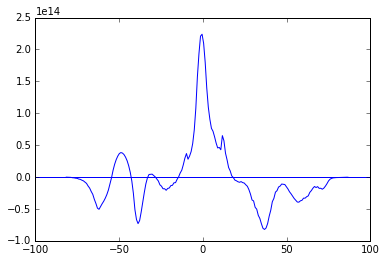

In [16]:
iplt.plot(hist_zonal_clim)
plt.axhline()
plt.show()

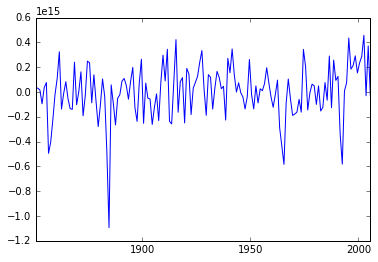

In [51]:
iplt.plot(hist_total_uptake)
plt.show()

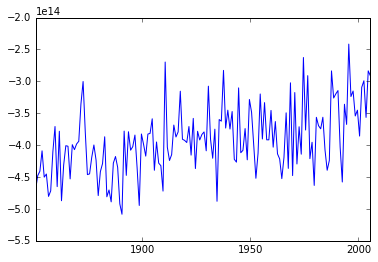

In [53]:
iplt.plot(hist_so_uptake)
plt.show()